In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import wandb
from wandb.integration.keras import WandbMetricsLogger

## Exploratory Image Analysis

In [53]:
base_dir = os.path.expanduser('dataset-resized')

See the sample images from each categories

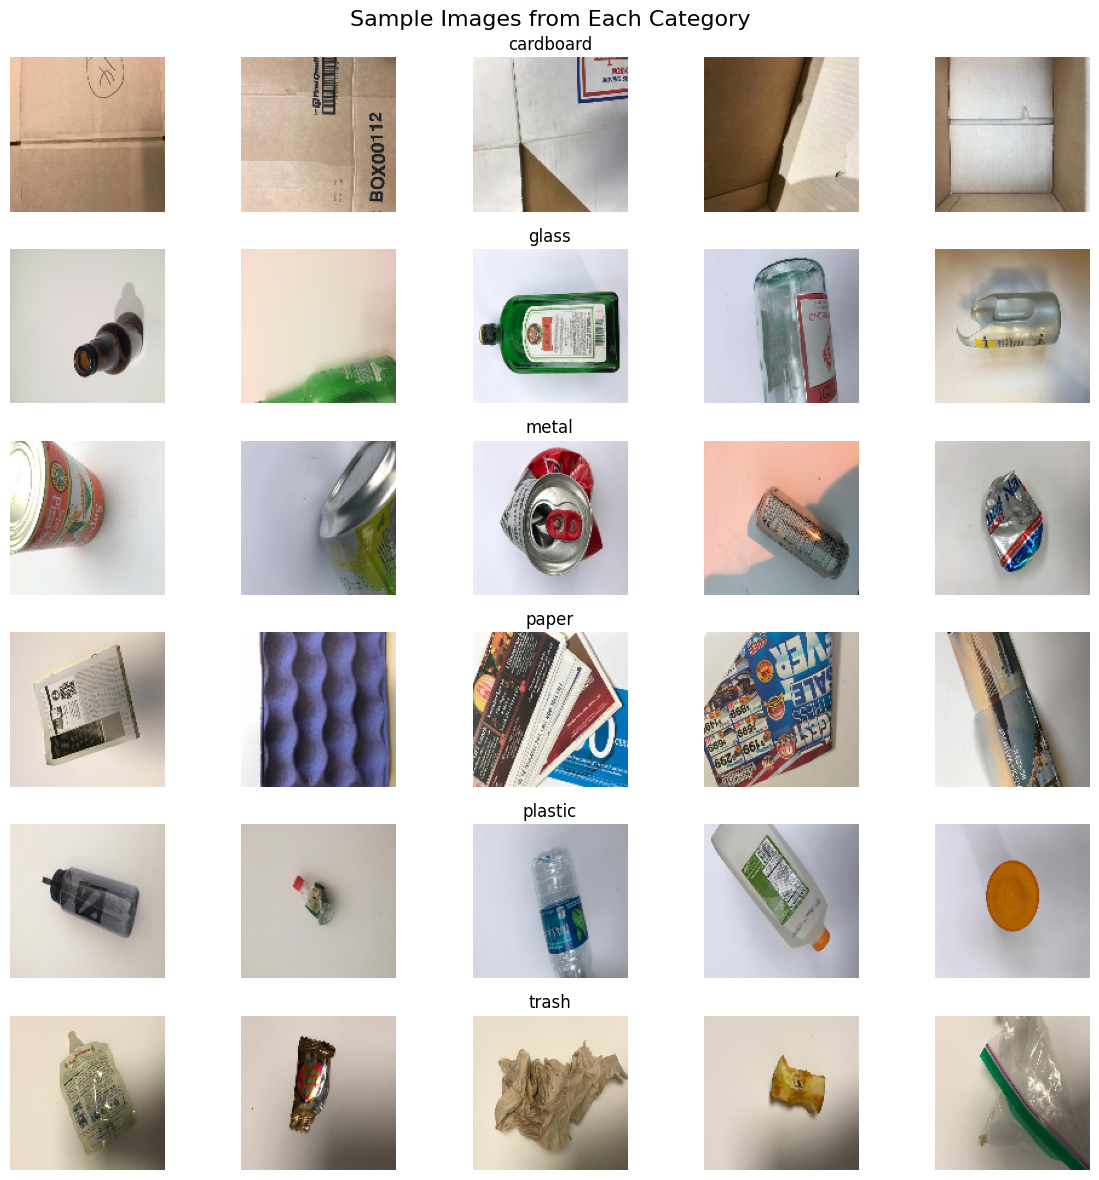

In [54]:
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

n_sample = 5

fig, axes = plt.subplots(nrows=len(categories), ncols=n_sample, figsize=(12, 12))
fig.suptitle('Sample Images from Each Category', fontsize=16)

for i, category in enumerate(categories):
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)[:n_sample]
    for j, img in enumerate(images):
        img_path = os.path.join(category_dir, img)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(category)

plt.tight_layout()
plt.show()

### Number of images per category

In [55]:
cat_counts = {}

for category in categories:
    cat_dir = os.path.join(base_dir, category)
    num_images = len([file for file in os.listdir(cat_dir) if os.path.isfile(os.path.join(cat_dir, file))])
    cat_counts[category] = num_images

print(cat_counts)

{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


It can be seen clearly that the `trash` category has the smallest proportion compared to the other categories.

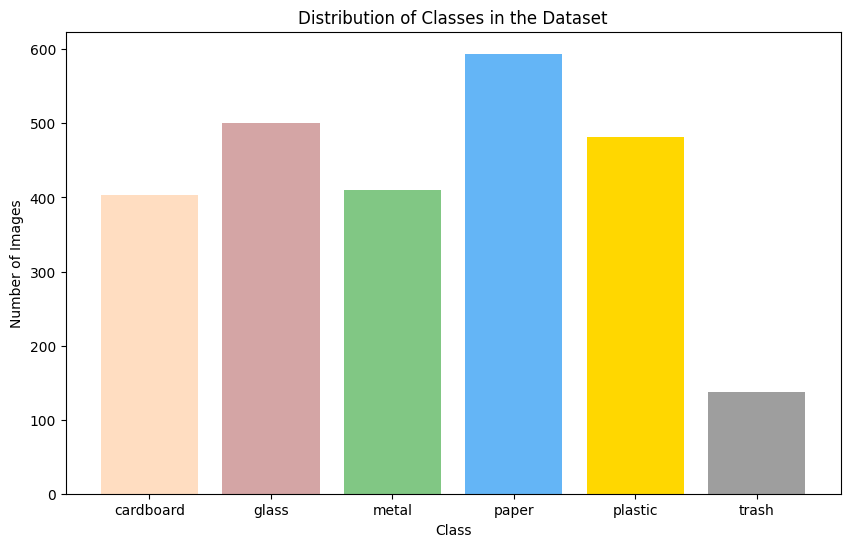

In [56]:
# Create lists for the classes and their respective counts
cat_names = list(cat_counts.keys())
counts = list(cat_counts.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(cat_names, counts, color=['#FFDDC1', '#D4A5A5', '#81C784', '#64B5F6', '#FFD700', '#9E9E9E'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Dataset')
plt.show()

### Create data generator

The data generator is created using 2 approach:
- With no data augmentation
- With more complex data augmentation

In theory, data augmentation will help the model to generalize properly in the presence of limited training dataset. The training and validation dataset is splitted with 80% and 20% proportion.

In [57]:
# With data augmentation
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

# # Without data augmentation 
# datagen = ImageDataGenerator(
#     validation_split=0.2
# )


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [58]:
train_generator.samples, train_generator.batch_size

(2024, 32)

In [59]:
validation_generator.samples, validation_generator.batch_size

(503, 32)

Below, we will see some sample augmented images from the training generators **this only works for the augmented training data**:

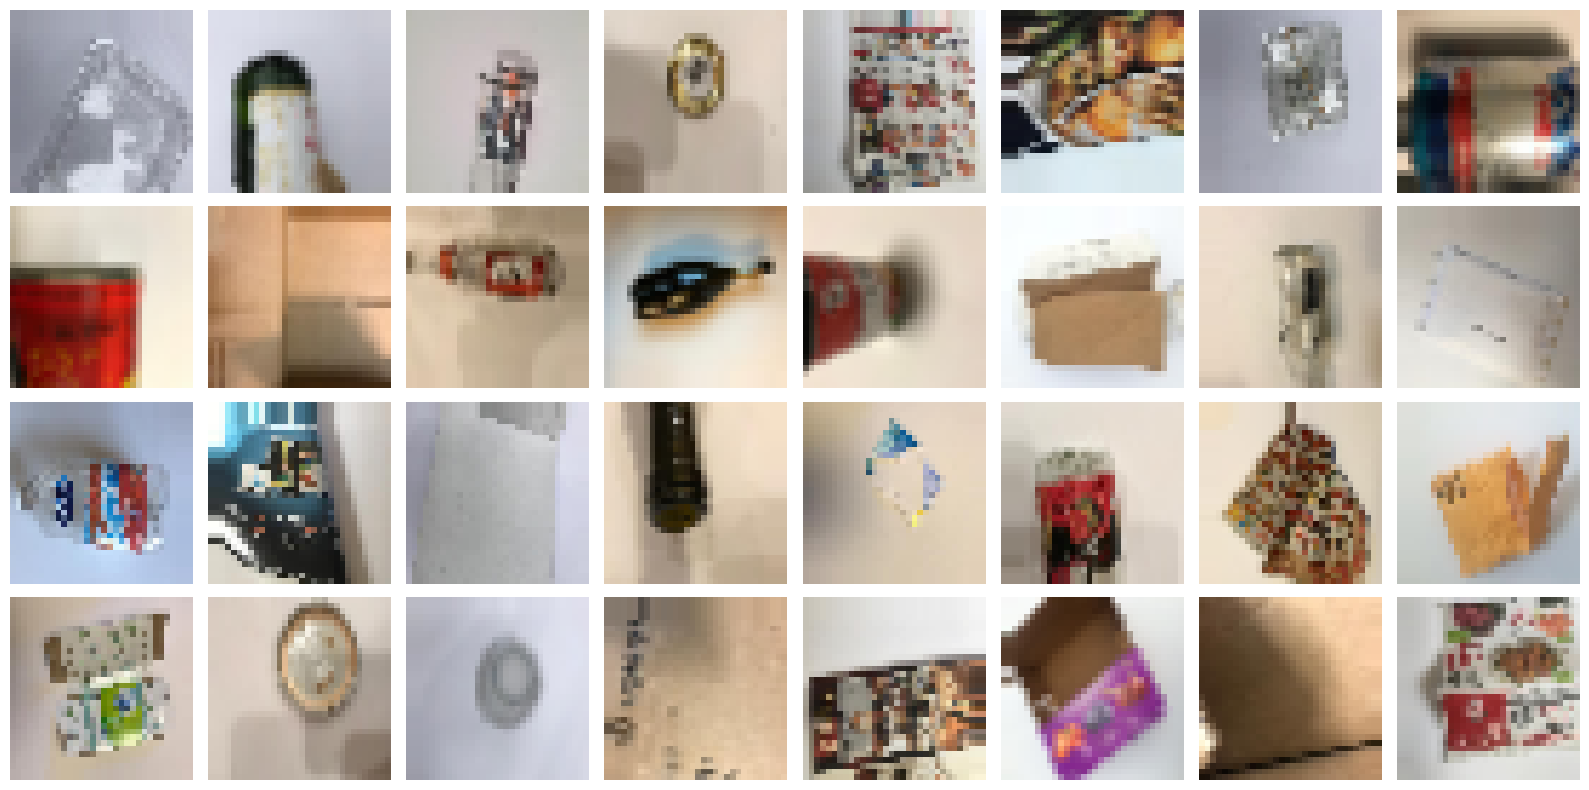

In [60]:
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(32):
    ax = axes[i // 8, i % 8]
    ax.imshow(x_batch[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

It looks like the input downscaling from `(128, 128)` to `(32, 32)` significantly reduces the quality of the images. This approach is used for the purpose of demonstration only since it can generate bias in the model.

## Model Experimentation

In [61]:
n_class = len(train_generator.class_indices)
print(n_class)

6


The experiment is tracked using Weight and Biases. All the logs created from the training process can be seen in this [workspace](https://wandb.ai/adamata-selection/wandb-trash-classification?nw=nwuseradvendiodesandros1).

In [63]:
run = wandb.init(
    project="wandb-trash-classification",
    config={
        "learning_rate": 0.001,
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 20
    }
)

config = wandb.config

i = Input(shape=(32, 32, 3))

# Convolutional Layers {Conv --> BatchNorm --> Conv --> BatchNorm --> MaxPooling (3x)}
x = Conv2D(32, (3,3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Neural Networks Layer
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(n_class, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer=Adam(learning_rate=config.learning_rate), 
              loss=config.loss, 
              metrics=[config.metric])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=config.epoch,
    callbacks=[
        WandbMetricsLogger()
    ]
)

# Save model locally
path = "./models/trash-classification-aug.keras"
weight_path = "./models/trash-classification-aug.weights.h5"
model.save(path)
model.save_weights(weight_path)

# Save model to W&B
path = "./models/trash-classification-aug.keras"
registered_model_name = "trash-classification-dev"

run.link_model(path=path, registered_model_name=registered_model_name)

print(f"The model has been trained and saved in W&B '{path}'")

wandb.finish()

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8:20 8s/step - accuracy: 0.1562 - loss: 2.658 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.1641 - loss: 3.754 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.1892 - loss: 4.072 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.2064 - loss: 4.311 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.2201 - loss: 4.56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.2355 - loss: 4.66 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.2522 - loss: 4.69 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.2666 - loss: 4.68 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.2767 - loss: 4.65 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.2841 - loss: 4.62 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.2897 - loss: 4.58 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.2942 - loss: 4.54 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.2980 - loss: 4.50 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.3026 - loss: 4.46 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - acc

C:\Users\adven\anaconda3\envs\trash-classification\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.2298 - val_accuracy: 0.2174 - val_loss: 1.9830
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 815ms/step - accuracy: 0.4062 - loss: 1.442 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4062 - loss: 1.524 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.4097 - loss: 1.52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.4030 - loss: 1.54 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.4049 - loss: 1.549 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.4086 - loss: 1.540 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.4127 - loss: 1.53 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.4183 - loss: 1.52 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.4243 - loss: 1.51 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.4296 - loss: 1.50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.4337 - loss: 1.49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.4379 - loss: 1.48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.4422 - lo

epoch/accuracy,▁▃▃▃▄▆▅▂▆▇▆▅▇▇▇▅▇█▇▇
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▄▄▃▃▂▂▃▂▁▂▂▂▁▂▁▁▁▁▂
epoch/val_accuracy,▃▂▂▅▃▂▂▂▃▁▄▄▄▃▆▅▆▇▇█
epoch/val_loss,▄▄▄▃▆▆▅▇▅█▅▅▄▅▂▃▄▂▄▁
epoch/accuracy,0.71875
epoch/epoch,19
epoch/loss,0.90649
epoch/val_accuracy,0.56522
epoch/val_loss,1.21877


### Model architecture

In [64]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,177,588 (27.38 MB)

 Trainable params: 2,392,230 (9.13 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 4,784,462 (18.25 MB)

**Architecture explanation**

Main CNN block:
- `Conv2D(32, (3,3), padding='same', activation='relu')`: Applies 32 convolutional filters of size 3x3 with ReLU activation. padding='same' ensures the output has the same width and height as the input.
- `BatchNormalization()`: Normalizes the output of the previous layer, which helps in stabilizing and speeding up the training.
- `MaxPooling2D(pool_size=(2,2))`: Reduces the spatial dimensions (height and width) by a factor of 2, keeping the most important features.

This block is repeated 3 times with doubled convolutional filters (32, 64, 128). 

- Output of the convolutional layers is flattened and regularized using the Dropout with 20% of the neurons set to zero.

- Then the output is connected to the dense layer with 1024 neurons with `relu` activation function and regularized again using the Dropout with 20% of the neurons set to zero

- At the end of the block, a dense layer with 6 neurons (same with the number of classes) with `softmax` activation function is set which converts the output into probability distributions.

### Tracking the training process with wandb

The image below is the model training history taken from wandb workspace to comppare effect of data augmentation method applied to the DataGenerator

<img src="./images/model_history.png" alt="wandb tracking" />

The run name `ethereal-puddle-72` represents the model training **without data augmentation** and `gentle-water-74` represents the model training **with data augmentation**.

We can see that the model with no data augmentation will overfit much faster than the model with data augmentation. The model trained with data augmentation will also perform much better along with the increasing epoch number due to the better generalisation. In the real case, we might try 30 - 45 epochs before we try other endeavours to  boost the performance. 

Better performance also can be gained by using the original image size so the small details (potentially will be good features) are kept.

## Push the model to Huggingface Hub

In this case, we're going to push the pre-trained models and their weights to the Huggingface Hub repository named `tensorflow-trash-classification`

### Push models

In [66]:
from huggingface_hub import HfApi

api = HfApi()

api.upload_file(
    path_or_fileobj="./models/trash-classification-no-aug.keras",
    path_in_repo="trash-classification-no-aug.keras",
    repo_id="diozhug/tensorflow-trash-classification",
    repo_type="model"
)

C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
trash-classification-no-aug.keras: 100%|██████████████████████████████████████████████████████████████| 28.8M/28.8M [00:02<00:00, 11.8MB/s]


CommitInfo(commit_url='https://huggingface.co/diozhug/tensorflow-trash-classification/commit/26b34f82bc7df1b0bf31ab39809517413267fea9', commit_message='Upload trash-classification-no-aug.keras with huggingface_hub', commit_description='', oid='26b34f82bc7df1b0bf31ab39809517413267fea9', pr_url=None, pr_revision=None, pr_num=None)

In [67]:
api.upload_file(
    path_or_fileobj="./models/trash-classification-aug.keras",
    path_in_repo="trash-classification-aug.keras",
    repo_id="diozhug/tensorflow-trash-classification",
    repo_type="model"
)

trash-classification-aug.keras: 100%|█████████████████████████████████████████████████████████████████| 28.8M/28.8M [00:02<00:00, 11.5MB/s]


CommitInfo(commit_url='https://huggingface.co/diozhug/tensorflow-trash-classification/commit/c28f41ccb812125a4a717c4c41be9b55075104af', commit_message='Upload trash-classification-aug.keras with huggingface_hub', commit_description='', oid='c28f41ccb812125a4a717c4c41be9b55075104af', pr_url=None, pr_revision=None, pr_num=None)

### Push weights

In [68]:
api.upload_file(
    path_or_fileobj="./models/trash-classification-no-aug.weights.h5",
    path_in_repo="trash-classification-no-aug.weights.h5",
    repo_id="diozhug/tensorflow-trash-classification",
    repo_type="model"
)

trash-classification-no-aug.weights.h5: 100%|█████████████████████████████████████████████████████████| 28.8M/28.8M [00:02<00:00, 14.2MB/s]


CommitInfo(commit_url='https://huggingface.co/diozhug/tensorflow-trash-classification/commit/0d45cc30fc2fa6a16ec88bcc8b8ba55777b422a3', commit_message='Upload trash-classification-no-aug.weights.h5 with huggingface_hub', commit_description='', oid='0d45cc30fc2fa6a16ec88bcc8b8ba55777b422a3', pr_url=None, pr_revision=None, pr_num=None)

In [69]:
api.upload_file(
    path_or_fileobj="./models/trash-classification-aug.weights.h5",
    path_in_repo="trash-classification-aug.weights.h5",
    repo_id="diozhug/tensorflow-trash-classification",
    repo_type="model"
)

trash-classification-aug.weights.h5: 100%|████████████████████████████████████████████████████████████| 28.8M/28.8M [00:01<00:00, 18.7MB/s]


CommitInfo(commit_url='https://huggingface.co/diozhug/tensorflow-trash-classification/commit/02033fb2cc133ea5d3458d50a19283fa35ec8925', commit_message='Upload trash-classification-aug.weights.h5 with huggingface_hub', commit_description='', oid='02033fb2cc133ea5d3458d50a19283fa35ec8925', pr_url=None, pr_revision=None, pr_num=None)